In [14]:
import os
import colorsys

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pylab as plt

from PIL import Image, ImageDraw

from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics import silhouette_score
from sklearn.neighbors import NearestNeighbors

from skimage import measure
from skimage import segmentation, color
from skimage.io import imread
from skimage.future import graph
from skimage import io, color
from skimage.transform import resize

%matplotlib inline

In [15]:
def convert_rgb_palette_to_lab(rgb_palette):
    if type(rgb_palette) is list:
        palette_reshaped = np.reshape(rgb_palette, (1, len(rgb_palette), 3)) / 255.
    else:
        palette_reshaped = rgb_palette / 255.

    palette_reshaped = color.rgb2lab(palette_reshaped)
    return [list(palette_reshaped[0][i]) for i in range(palette_reshaped.shape[1])] 

def convert_lab_palette_to_rgb(lab_palette):
    if type(lab_palette) is list:
        palette_reshaped = np.reshape(lab_palette, (1, len(lab_palette), 3))
    else:
        palette_reshaped = lab_palette
    palette_reshaped = (color.lab2rgb(palette_reshaped) * 255).astype(np.float32).astype(int)
    return [list(palette_reshaped[0][i]) for i in range(palette_reshaped.shape[1])] 

def get_all_rgbs(image_array, labels):
    rgbs_big = []
    for i in np.unique(labels): 
        rgbs = image_array[labels==i, :].tolist()
        rgbs_big.append(rgbs)
    
    return rgbs_big 

def read_motif_as_array(name, show_im=False, change_space=False):
    img_r = io.imread("/home/salim/Documents/playground/iznik/project-iznik/data/motifs_22-05-19/" + name + "_intensity_image_r.png")
    img_g = io.imread("/home/salim/Documents/playground/iznik/project-iznik/data/motifs_22-05-19/" + name + "_intensity_image_g.png")
    img_b = io.imread("/home/salim/Documents/playground/iznik/project-iznik/data/motifs_22-05-19/" + name + "_intensity_image_b.png")
    mask = io.imread("/home/salim/Documents/playground/iznik/project-iznik/data/motifs_22-05-19/" + name + "_mask.png")

    img = np.zeros((img_r.shape[0], img_r.shape[1], 3)).astype(int)
    img[...,0] = ((img_r / 65535) * 255).astype(int)
    img[...,1] = ((img_g / 65535) * 255).astype(int)
    img[...,2] = ((img_b / 65535) * 255).astype(int)
    img_to_show = img.copy()
    
    if change_space: #rgb_to_lab
        img = color.rgb2lab(img.astype(np.float32) / 255.)
        
    w, h, d = original_shape = tuple(img.shape)
    assert d == 3
    image_array = np.reshape(img, (w * h, d))
    mask_array = np.reshape(mask, (w * h))
    
    if show_im:
        plt.figure()
        plt.imshow(img_to_show)
        
    return image_array, mask_array, img_to_show


def kmeans_fn(image_array, mask_array=None, n_colors=16, normalise=False, change_space=False):
    """
    image_array is a an array of n x 3, where 3 is the size of channels (R, G, B)
    """        
    if mask_array is None:
        mask_array = np.ones(image_array.shape[0])
    
    clustering = KMeans(n_clusters=n_colors, random_state=0)

    X = image_array[mask_array > 0]
    if normalise:
        scaler = StandardScaler()
        X = scaler.fit_transform(X)
    
    clustering = clustering.fit(X)
    labels_masked = clustering.labels_
    
    palette = [np.mean(image_array[mask_array > 0][labels_masked==i, :], axis=0).tolist() for i in range(n_colors)]
    labels = np.full(mask_array.shape, 0)
    labels[mask_array > 0] = labels_masked + 1
    color_codes = get_all_rgbs(image_array[mask_array > 0], labels_masked)
    
    if change_space: # LAB_to_RGB
        palette = convert_lab_palette_to_rgb(palette)
        rgbs = [convert_lab_palette_to_rgb(color_codes_i) for color_codes_i in color_codes] 
    else:
        palette = [[int(p) for p in pp] for pp in palette]
        rgbs = color_codes
    
    return labels_masked, palette, rgbs

def append_to_palette(palette):
    """
    Reshape palette so that there is at most MAX_LINE colors per line.
    """
    to_append_num = ((len(palette) // MAX_LINE) + 1) * MAX_LINE - len(palette)
    for i in range(to_append_num):
        palette.append([255, 255, 255])
    return palette

def initial_palettes_for_motifs(motif_names, n_colors=8, change_space=False, normalise=False):
    images = []
    palettes_each = []
    labels_each = []
    rgbs_each = []
    failed = []
    for name in motif_names: 
        image_array, mask_array, img = read_motif_as_array(name, show_im=False, change_space=change_space)
        images.append(img.astype(np.uint8))
        try:
            labels, palette_each, rgbs, = kmeans_fn(
                image_array, mask_array, n_colors, change_space=change_space, normalise=normalise
            )
        except ValueError:
            failed.append(name)
            continue
        palettes_each.append(palette_each)
        labels_each.append(labels)
        rgbs_each.append(rgbs)
    return palettes_each, labels_each, rgbs_each, images, failed


def first_agglomerative_palettes(
    palettes_each, 
    n_clusters=4, 
    linkage="ward", 
    normalise=False, 
    show_and_save=False, 
    names=None,
    motif_type="all"
):
    """
    Given a list of palettes for an image, apply first level agglomerative clustering
    """
    if (show_and_save == True) and (names is None):
        raise ValueError("When showing and saving palette, names must be provided.")
        
    scaler = StandardScaler()
    palette_merged = []
    for i, palette in enumerate(palettes_each):
        palette_merged += palette
        lab_array = convert_rgb_palette_to_lab(palette)
        if normalise:
            scaler = StandardScaler()
            lab_array = scaler.fit_transform(lab_array)
        clustering = AgglomerativeClustering(linkage=linkage, n_clusters=n_clusters).fit(lab_array)
    
        centers = [
            np.mean(np.array(palette)[clustering.labels_ == i, :], axis=0).astype(np.uint8).tolist() for i in range(n_clusters)
        ]

        if show_and_save:            
            fig = plt.figure(figsize=(6,10))
            plt.subplot(1, 2, 1)
            plt.title(names[i])
            plt.imshow(images[i])
            plt.subplot(1, 2, 2)
            plt.imshow(np.reshape(sorted(centers), (1, len(centers), 3)).astype(np.uint8))
            plt.savefig(ROOT_DIR + motif_type + "/" + names[i] + "_palette_" + str(n_clusters) + ".png")
            plt.close()
    
    return palette_merged

def second_agglomerative_palettes(
    palette, 
    im_name, 
    linkage="ward", 
    normalise=False, 
    max_clusters=12, 
    motif_type="all"
):
    """
    Given an initial palette for an image, apply second level agglomerative clustering at various resolutions
    """
    scs = []
    center_dict = {}
    label_dict = {}
    scaler = StandardScaler()
    for n_clusters in range(4, min(len(palette), max_clusters + 1)): # this was 20 initially
        lab_array = convert_rgb_palette_to_lab(palette)
        if normalise:
            scaler = StandardScaler()
            lab_array = scaler.fit_transform(lab_array)
        clustering = AgglomerativeClustering(linkage=linkage, n_clusters=n_clusters).fit(lab_array)
        sc = silhouette_score(lab_array, clustering.labels_)
        centers = [np.mean(np.array(palette)[clustering.labels_ == i, :], axis=0).astype(int).tolist() for i in range(n_clusters)]
        center_dict[n_clusters] = centers
        label_dict[n_clusters] = clustering.labels_
        np.save(ROOT_DIR + motif_type + "/data/" + im_name + "_colors_" + str(n_clusters) + ".npy", centers)
        scs.append(sc)

        plt.figure()
        plt.imshow(np.reshape(sorted(centers), (1, n_clusters, 3)).astype(np.uint8))
        plt.title("n: " + str(n_clusters) + " sc: " + str(sc))
        plt.savefig(ROOT_DIR + motif_type + "/" + im_name + "_palette_reduced_" + str(n_clusters) + ".png")
        plt.close()
    return center_dict, label_dict

def final_agglomerative_palettes(
    palette, motif, prefix="", n_clusters=30, linkage="ward", normalise=False, show=False, sort_palette=True
):
    scs = []
    scaler = StandardScaler()
    lab_array = convert_rgb_palette_to_lab(palette)
    if normalise:
        scaler = StandardScaler()
        lab_array = scaler.fit_transform(lab_array)
    clustering = AgglomerativeClustering(linkage=linkage, n_clusters=n_clusters).fit(lab_array)
    sc = silhouette_score(lab_array, clustering.labels_)
    centers = [np.mean(np.array(palette)[clustering.labels_ == i, :], axis=0).astype(int).tolist() for i in range(n_clusters)]
    labels = clustering.labels_

    scs.append(sc)
    if show:
        plt.figure()
        if sort_palette:
            plt.imshow(np.reshape(sorted(centers), (1,n_clusters,3)).astype(np.uint8))
        else:
            plt.imshow(np.reshape(centers, (1,n_clusters,3)).astype(np.uint8))
        plt.title("n: " + str(n_clusters) + " sc: " + str(sc))
    
    return centers, lab_array, labels

def get_palette_from_dict(palette_dict, motif, n_clusters):
    """Final agglomerative clutering on the whole set for given resolution 
    """
    palette = []
    for im_name, val in palette_dict[motif].items():
        try:
            data = val[n_clusters] 
        except KeyError: # This is required in case palette has less than n_clusters colors
            for n in range(4, n_clusters)[::-1]:
                try:
                    data = val[n]
                except KeyError:
                    continue
                break
        palette += data 
    return palette

def save_image_palettes_as_whole(palette, im_name, motif_type="all"):
    palette_appended = append_to_palette(palette.copy())
    if len(palette) > MAX_LINE:    
        palette_reshaped = np.reshape(
            palette_appended, (len(palette_appended) // MAX_LINE, MAX_LINE, 3)
        )
    else:
        palette_reshaped = np.reshape(palette, (1, len(palette), 3))

    rgbs_sorted = sorted(palette.copy())
    if len(palette) > MAX_LINE:
        rgbs_sorted = append_to_palette(rgbs_sorted)
    palette_rgb_sorted_reshaped = np.reshape(
        rgbs_sorted, (max(1, len(rgbs_sorted) // MAX_LINE), min(len(palette), MAX_LINE), 3)
    ).astype(np.uint8)
    
    fig = plt.figure(figsize=(20, (len(palette) // MAX_LINE) + 3))
    plt.subplot(1, 1, 1)
    plt.imshow(palette_rgb_sorted_reshaped)
    plt.title(im_name + " palette (8-palette motifs combined, sorted)")    
    
    fig1 = plt.gcf()
    plt.show()
    plt.draw()

    fig1.savefig(ROOT_DIR + motif_type + "/" + im_name + "_motif_based_palette.png")
    plt.close()
    
def show_save_palette(palette_as_list, prefix, sort=False, save=False):
    
    fig = plt.figure(figsize=(12, 4))
    plt.subplot(1, 1, 1)
    if sort:
        palette_as_list = sorted(palette_as_list)
        prefix += "_sorted"
    
    palette = np.reshape(palette_as_list, (1, len(palette_as_list), 3)).astype(np.uint8)
    plt.imshow(palette)
    plt.title(prefix)    
    
    fig1 = plt.gcf()
    plt.show()
    plt.draw()
    
    if save:
        fig1.savefig(ROOT_DIR + "final/" + prefix + "_motif_based_palette.png")
    plt.close()

def show_final_palettes(palette):
    palette_appended = append_to_palette(palette.copy())
    if len(palette) > MAX_LINE:    
        palette_reshaped = np.reshape(
            palette_appended, (len(palette_appended) // MAX_LINE, MAX_LINE, 3)
        ).astype(np.uint8)
    else:
        palette_reshaped = np.reshape(palette, (1, len(palette), 3)).astype(np.uint8)

    rgbs_sorted = sorted(palette.copy())
    if len(palette) > MAX_LINE:
        rgbs_sorted = append_to_palette(rgbs_sorted)
    palette_rgb_sorted_reshaped = np.reshape(
        rgbs_sorted, (max(1, len(rgbs_sorted) // MAX_LINE), min(len(palette), MAX_LINE), 3)
    ).astype(np.uint8)

    hsvs = sorted([colorsys.rgb_to_hsv(*rgb) for rgb in palette.copy()])
    hsvs_sorted = [list(map(int, colorsys.hsv_to_rgb(*hsv))) for hsv in hsvs]
    if len(palette) > MAX_LINE:
        hsvs_sorted = append_to_palette(hsvs_sorted)
    palette_hsv_sorted_reshaped = np.reshape(
        hsvs_sorted, (max(1, len(hsvs_sorted) // MAX_LINE), min(len(palette), MAX_LINE), 3)
    ).astype(np.uint8)


    fig = plt.figure(figsize=(15, 5))
    plt.subplot(3, 1, 1)
    plt.imshow(palette_reshaped)
    plt.title("palette")
    plt.subplot(3, 1, 2)
    plt.imshow(palette_rgb_sorted_reshaped)
    plt.title("rgb-sorted")
    plt.subplot(3, 1, 3)
    plt.imshow(palette_hsv_sorted_reshaped)
    plt.title("hsv-sorted")
    plt.tight_layout()

    fig1 = plt.gcf()
    plt.show()
    plt.draw()
    plt.close()
    
    
def expert_palette():
    ## Expert palette
    palette_lookup = {
        "black_1": {"name": "black_outline", "rgb": [46, 49, 65], "hex": "#2E3141"}, 
        "blue_1": {"name": "bright_cobalt_blue", "rgb": [49, 71, 138], "hex": "#31478A"}, 
        "blue_2": {"name": "lilac_blue", "rgb": [138, 157, 199], "hex": "#8A9DC7"},
        "blue_3": {"name": "dark_blue", "rgb": [45, 52, 75], "hex": "#2D344B"},
        "blue_4": {"name": "pale_blue", "rgb": [107, 145, 174], "hex": "#6B91AE"},
        "blue_5": {"name": "blue_green",  "rgb": [116, 152, 140], "hex": "#74988C"},
        "green_1": {"name": "sage_green", "rgb": [123, 129, 106], "hex": "#7B816A"}, 
        "green_2": {"name": "emerald_green", "rgb": [33, 121, 102], "hex": "#217966"}, 
        "green_3": {"name": "dark_green", "rgb": [45, 68, 52], "hex": "#2D4434"},
        "green_5": {"name": "pale_green", "rgb": [170, 205, 147], "hex": "#AACD93"},
        "purple_1": {"name": "dark_purple", "rgb": [106, 106, 142], "hex": "#6A6A8E"},
        "purple_2": {"name": "medium_purple", "rgb": [143, 147, 172], "hex": "#8F93AC"}, 
        "purple_3": {"name": "pale_purple", "rgb": [178, 165, 175], "hex": "#B2A5AF"},
        "red_1": {"name": "thin_orange_red", "rgb": [148, 99, 69], "hex": "#946345"},
        "red_2": {"name": "bright_red", "rgb": [186, 78, 65], "hex": "#BA4E41"},
        "red_3": {"name": "dark_brick_red", "rgb": [117, 66, 34], "hex": "#754222"},
        "turquoise_1": {"name": "clear turquoise", "rgb": [124, 179, 211], "hex": "#7CB3D3"},
        "turquoise_2": {"name": "greenish_turquoise", "rgb": [82, 136, 127], "hex": "#52887F"}
    }

    rgbs = []
    for key, value in palette_lookup.items():
        rgbs.append(value["rgb"])
    labs = convert_rgb_palette_to_lab(rgbs)
    return rgbs, labs

def compute_adjacency_matrix(expert_labs, final_array, n_neighbors=1, normalise=False):
    if normalise:
        scaler = StandardScaler()
        expert_labs = scaler.fit_transform(expert_labs)
    nbrs = NearestNeighbors(n_neighbors=n_neighbors, algorithm='auto', metric="euclidean").fit(expert_labs)
    distances, indices = nbrs.kneighbors(final_array)
    indices = np.array([index[-1] for index in indices])
    
    A = np.zeros((len(final_array), len(final_array)))
    #for n in range(n_neighbors):
    for i in range(len(expert_labs)):
        group = np.argwhere(indices == i)   
        for j in group:
            for k in group:
                A[j,k] = 1

    return A

In [16]:
# It all starts here with initialising some data structures and setting some (hyper-)parameters
palette_dict = dict() # dictionary for palettes
label_dict = dict() # dictionary for labels

MAX_LINE = 100 # For visualisation. Sets how many colors will be shown on each line of a (huge) palette
ROOT_DIR = "/home/salim/Documents/playground/iznik/project-iznik/data/palette_temp/" # save output into
MOTIF_CSV = "/home/salim/Documents/playground/iznik/project-iznik/data/motif_props_all_21-06-19_with_bg.csv"

change_space = True # To perform clustering in LAB rather than in RGB space
normalise = False # Normalise colors
linkage = "ward" # Linkage rule (i.e. how to combine to clusters at a time) for hierarchical clustersing
motif_type = "all" # Run algorithm for which motif (saz, carnation, tulip, or all)
hist_csv = 32 # How many bins will read from the CSV
n_motif_initial = 8 # How many colors each motif will be represented initially with 
                    # (better to have a larger number than of the below)
n_motif_colors = 4 # How many colors each motif will be represented with after the first agglomerative clustering

# Make directories if not exist
if not os.path.exists(ROOT_DIR):
    os.mkdir(ROOT_DIR)
if not os.path.exists(os.path.join(ROOT_DIR, motif_type)):
    os.mkdir(os.path.join(ROOT_DIR, motif_type))
if not os.path.exists(os.path.join(ROOT_DIR, motif_type, "data")):
    os.mkdir(os.path.join(ROOT_DIR, motif_type, "data"))

In [17]:
# Read data and generate auxiliary data structures
roster = pd.read_csv(MOTIF_CSV)

hist_columns = [
    "hist" + str(hist_csv) + "_" + str(i) + "_" + c for c in ["r", "g", "b"] for i in range(hist_csv)
]
if motif_type == "all":
    motifs = roster[roster["tulip"]==1] 
    motifs = motifs.append(roster[roster["saz"]==1]) 
    motifs = motifs.append(roster[roster["carnation"]==1])
else:
    motifs = roster[roster[motif_type]==1]
    
X = np.array(motifs[hist_columns])
names_X = np.array(motifs["ID"])

name_to_motif_lookup = {} # Given an image name, list all of its motifs
name_to_label_lookup = {} # Assign a label to all images. Used to populate y.
label = 0
for name in names_X:
    name_s = name.split("_")[0]
    try:
        name_to_motif_lookup[name_s].append(name)
    except KeyError:
        name_to_label_lookup[name_s] = label
        label += 1
        name_to_motif_lookup[name_s] = [name]
        
y = []
for key, value in name_to_motif_lookup.items():
    for val in value:
        y.append(name_to_label_lookup[key])
y = np.array(y)

X.shape, names_X.shape, y.shape

((4080, 96), (4080,), (4080,))

AM04 ['AM04_1', 'AM04_2', 'AM04_3', 'AM04_4', 'AM04_0']


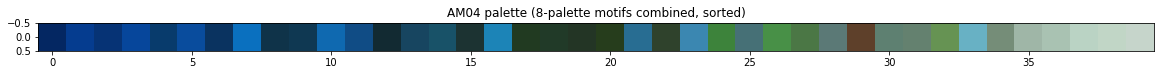

In [18]:
# Palette generation for one image, i.e. AM03 just to get a feeling
im_name = "AM04"
palette_dict[motif_type] = {}
motif_names = name_to_motif_lookup[im_name]
print(im_name, motif_names)
palettes_each_motif, _, _, images, failed = initial_palettes_for_motifs(
    motif_names, n_motif_initial, change_space, normalise
)
palette_image = first_agglomerative_palettes(
    palettes_each_motif, n_motif_initial, linkage, normalise, show_and_save=True, names=motif_names, motif_type=motif_type)
save_image_palettes_as_whole(palette_image, im_name, motif_type)
im_palettes, _ = second_agglomerative_palettes(palette_image, im_name, linkage, normalise, motif_type=motif_type)
palette_dict[motif_type][im_name] = im_palettes

In [19]:
# Run for all while keeping track of RGB values per pixel
rgb_roster_list = []
i = 1
motif_i = 0
palette_dict[motif_type] = {}
label_dict[motif_type] = {}
for im_name, motif_names in name_to_motif_lookup.items():
    
    print(str(i) + "/{}".format(len(name_to_motif_lookup.items())), im_name, len(rgb_roster_list))
    palettes_each_motif, labels_each_motif, rgbs_each_motif, images, failed = initial_palettes_for_motifs(
        motif_names, n_motif_initial, change_space, normalise
    )
    palette_merged = []
    for palette in palettes_each_motif:
        palette_merged += palette
        
    im_palettes, im_labels = second_agglomerative_palettes(
        palette_merged, im_name, linkage, normalise, motif_type=motif_type)
    
    for fail in failed:
        motif_names.remove(fail)
        
    assert(len(motif_names) == len(labels_each_motif))
    
    l_i = 0
    for j, motif_name in enumerate(motif_names):
        labels = labels_each_motif[j]
        for motif_label in np.unique(labels):
            rgbs_j = rgbs_each_motif[j][motif_label]
            im_label = im_labels[list(im_labels.keys())[-1]][l_i]
            l_i += 1
            for pixel, (R, G, B) in enumerate(rgbs_j):
                rgb_roster_list.append([motif_name, pixel, motif_label, im_label, 0, R, G, B])
                motif_i += 1
    
    
    palette_dict[motif_type][im_name] = im_palettes
    label_dict[motif_type][im_name] = im_labels
    i += 1
    if i == 10:
        break

1/403 AM03 0
2/403 AM04 26766
3/403 AM05 53643
4/403 AM06 65825
5/403 AM07 113516
6/403 BEN01 131743
7/403 BEN03 262111
8/403 BEN04 268870
9/403 BEN05 280796


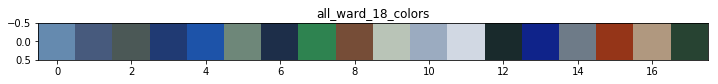

,code,R,G,B
0,0,101,138,175
1,1,71,90,125
2,2,75,88,86
3,3,32,58,115
4,4,29,83,169
5,5,110,135,121
6,6,29,46,73
7,7,46,131,80
8,8,118,77,55
9,9,185,196,183


In [20]:
# Final palette generation
impose = False
cluster_level = 12
n_final = 18
linkage = "ward"
n_neighbors = 1
sort = False
expert_rgbs, expert_labs = expert_palette()
  
if not impose:
    palette = get_palette_from_dict(palette_dict, motif_type, cluster_level)
    final_palette, final_array, final_labels = final_agglomerative_palettes(
        palette, motif_type, "unconstrained_palette", n_final, linkage, normalise, False
    )
else:
    A = compute_adjacency_matrix(expert_labs, final_array, n_neighbors, normalise)
    clustering = AgglomerativeClustering(linkage=linkage, n_clusters=n_final, connectivity=A).fit(final_array)
    final_palette = [
        np.mean(np.array(palette)[
            clustering.labels_ == i, :
        ], axis=0).astype(int).tolist() for i in range(n_final)
    ]
    final_labels = clustering.labels_

show_save_palette(final_palette, motif_type + "_" + linkage + "_" + str(n_final) + "_colors", sort)

palette_csv = pd.DataFrame(
    columns=["code", "R", "G", "B"]
)
pal_i = 0
for i, pal in enumerate(final_palette):
    palette_csv.loc[pal_i] = [str(i)] + pal
    pal_i += 1
if impose:
    palette_csv.to_csv("palette_" + str(n_final) + "_constrained.csv", index=False)
else:
    palette_csv.to_csv("palette_" + str(n_final) + "_unconstrained.csv", index=False)
palette_csv

In [ ]:
# Frequency computation part 1, generate label_dict_final for retrospective indexing of labels

palette = []
label_dict_final = {}
pivot = 0
for im_name, val in palette_dict[motif_type].items():
    try:
        data = val[cluster_level]
    except KeyError:
        for n in range(4, cluster_level)[::-1]:
            try:
                data = val[n]
            except KeyError:
                continue
            n_clusters = n
            break
    palette += data 
    label_dict_final[im_name] = final_labels[pivot:(pivot+len(data))]
    pivot += len(data)

In [ ]:
# Frequency computation part 2
# Manipulate rgb_roster_list to include labels generated above
pixel_i = 0
for count, (im_name, val) in enumerate(label_dict["all"].items()):
    print(count, im_name)
    item_found = False
    while pixel_i < len(rgb_roster_list):
        item = rgb_roster_list[pixel_i]
        if item[0].startswith(im_name):
            item[4] = label_dict_final[im_name][item[3]]
            rgb_roster_list[pixel_i][4] = label_dict_final[im_name][item[3]]
            item_found = True
            pixel_i += 1
            continue
        if item_found:
            break

In [ ]:
# Frequency computation part 3: Generate data frame with frequencies of each motif

palette_columns = ["count_" + str(i) for i in range(n_final)]
freq_columns =  ["perc_" + str(i) for i in range(n_final)]
freqs_palette = pd.DataFrame(
    columns=["ID"] + palette_columns + ["sum"] + freq_columns
)

pixel_i = 0
motif_i = 0
for j, (key, value) in enumerate(name_to_motif_lookup.items()):
    print(str(j) + "/{}".format(len(name_to_motif_lookup.items())), key, motif_i)
    for val in value:
        freqs = [0] * n_final
        item_found = False
        while pixel_i < len(rgb_roster_list):
            item = rgb_roster_list[pixel_i]
            if item[0] == val:
                freqs[item[4]] += 1
                item_found = True
                pixel_i += 1
                continue
            if item_found:
                freqs_perc = [np.round(freq / sum(freqs) * 100, 2) for freq in freqs]
                freqs_final = [val] + freqs + [sum(freqs)]
                break
        if pixel_i == len(rgb_roster_list):
            freqs_perc = [np.round(freq / sum(freqs) * 100, 2) for freq in freqs]
            freqs_final = [val] + freqs + [sum(freqs)]
        freqs_palette.loc[motif_i] = freqs_final + freqs_perc
        motif_i += 1

# save freqs
if impose:
    freqs_palette.to_csv("freqs_palette_" + str(n_final) + "_constrained.csv", index=False)
else:
    freqs_palette.to_csv("freqs_palette_" + str(n_final) + "_unconstrained.csv", index=False)

In [ ]:
freqs_palette

In [ ]:
# TEST
pal = get_palette_from_dict(palette_dict, "all", 12)
show_final_palettes(pal)
final_palette = final_agglomerative_palettes(
    pal, "tulip", "unconstrained_palette", 18, "average", normalise, show=True, sort_palette=True
)

In [ ]:
# TEST
# Show final, unconstrained palette before and after clustering
n_final = 18
palette_all = get_palette_from_dict(palette_dict, "all", 12)
show_final_palettes(pal)
final_palette = final_agglomerative_palettes(
    palette_all,
    motif="tulip", 
    prefix="unconstrained_palette", 
    n_clusters=18, 
    linkage="average", 
    normalise=False, 
    show=True, 
    sort_palette=True
)

In [ ]:
# TEST
# Generate and show uncosntrained, constrained and expert palettes for n_final
n_final = 18
n_neighbors = 1 #Required for the constrained palette
sort = False
motif_type = "all"
expert_rgbs, expert_labs = expert_palette() 
palette = get_palette_from_dict(palette_dict, motif_type, n_clusters=12)
final_palette, final_array, unconst_labels = final_agglomerative_palettes(
    palette, motif, "unconstrained_palette", n_final, linkage, normalise, sort
)

A = compute_adjacency_matrix(expert_labs, final_array, n_neighbors, normalise)
clustering = AgglomerativeClustering(linkage=linkage, n_clusters=n_final, connectivity=A).fit(final_array)
final_constrained = [
    np.mean(np.array(palette)[
        clustering.labels_ == i, :
    ], axis=0).astype(int).tolist() for i in range(n_final)
]
const_labels = clustering.labels_

show_save_palette(final_constrained, motif_type + "_constrained_" + linkage + "_" + str(n_final) + "_colors", sort)
show_save_palette(expert_rgbs, motif_type + "_expert_" + linkage + "_" + str(18) + "_colors", sort)
show_save_palette(final_palette, motif_type + "_unconstrained_" + linkage + "_" + str(n_final) + "_colors", sort)